## Avances de laboratorio

Instalaciones necesarias

In [ ]:
# !pip install wordcloud
# !pip install vaderSentiment

In [ ]:
# Importación de librerías

import pandas as pd
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

### 2) Carga del dataset/Descripción de los datos

In [ ]:
df = pd.read_csv("train.csv")  
print(df.info())
df.head()

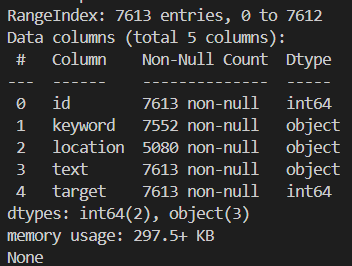

El dataset contiene 7,613 tweets con las siguientes columnas:

- id: Identificador
- Keyword: Palabra clave (A veces falta)
- location: lugar (hay muchos valores faltantes)
- text: el contenido del tweet
- target: etiqueta (1 = desastre, 0 = no desastre)

### 3) Limpieza y Preprocesamiento

In [ ]:
stop_words = set([
    # stopwords básicas
    "the","a","an","in","on","and","or","but","if","at","by","for","with",
    "about","against","between","into","through","during","before","after",
    "to","from","up","then","once","here","there","when","where","why","how",
    "all","any","both","each","few","more","most","other","some","such","no",
    "nor","not","only","own","same","so","than","too","very","is","are","was",
    "were","be","been","being","of","do","does","did","doing","would","could",
    "should","can","will",

    # pronombres
    "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
    "yourself","yourselves","he","him","his","himself","she","her","hers",
    "herself","it","its","itself","they","them","their","theirs","themselves",

    # palabras de twitter / conversación
    "amp","rt","im","dont","cant","didnt","doesnt","youre","youve","ive","id",
    "ill","hes","shes","theyre","weve","lets","lol","omg","ugh","got","like",
    "just","know","time","new","day","love","people","going","good","think",
    "want","really","one"
])

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z0-9\s]", "", text)
    
    # Manejo de números: conservar 911 y algunos con palabras relevantes
    tokens = text.split()
    clean_tokens = []
    for i, tok in enumerate(tokens):
        if tok.isdigit():
            if tok == "911":
                clean_tokens.append(tok)
            elif i+1 < len(tokens) and tokens[i+1] in ["dead", "injured", "wounded", "killed"]:
                clean_tokens.append(tok)
            elif i > 0 and tokens[i-1] == "magnitude":
                clean_tokens.append(tok)
        else:
            clean_tokens.append(tok)
    
    # Quitar stopwords y palabras de 1 caracter
    clean_tokens = [w for w in clean_tokens if w not in stop_words and len(w) > 1]
    
    return " ".join(clean_tokens)

df["clean_text"] = df["text"].apply(clean_text)
df[["text", "clean_text"]].head(10)

### Unigramas y bigramas

### 4) Frecuencia de palabras por categoría

In [ ]:
# Vectorizar con unigramas y bigramas
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=list(stop_words), max_features=5000, min_df=5, max_df=0.9)
X_tfidf = vectorizer.fit_transform(df["clean_text"])
feature_names = vectorizer.get_feature_names_out()

disaster_rows = np.flatnonzero(df["target"].to_numpy() == 1)
non_disaster_rows = np.flatnonzero(df["target"].to_numpy() == 0)

# Promedio de pesos TF-IDF por categoría
disaster_mean = X_tfidf[disaster_rows].mean(axis=0).A1 
non_disaster_mean = X_tfidf[non_disaster_rows].mean(axis=0).A1

# Top 20 palabras con más peso en cada clase
top_disaster = sorted(zip(disaster_mean, feature_names), reverse=True)[:20]
top_non_disaster = sorted(zip(non_disaster_mean, feature_names), reverse=True)[:20]

print("Top 20 términos en tweets de desastres:")
for score, word in top_disaster:
    print(word, round(float(score), 4))

print("\nTop 20 términos en tweets de NO desastres:")
for score, word in top_non_disaster:
    print(word, round(float(score), 4))

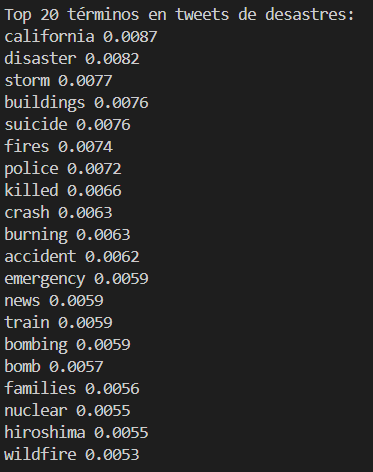

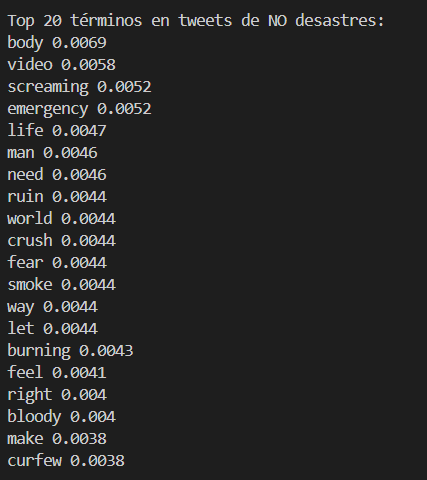

### 5) Análisis exploratorio

In [ ]:
# 5.1 "Palabra más repetida" por categoría
cv = CountVectorizer(ngram_range=(1,2), stop_words=list(stop_words), max_features=5000, min_df=5, max_df=0.9)
X_count = cv.fit_transform(df["clean_text"])
vocab = cv.get_feature_names_out()

disaster_counts = np.asarray(X_count[disaster_rows].sum(axis=0)).ravel()
non_disaster_counts = np.asarray(X_count[non_disaster_rows].sum(axis=0)).ravel()

top_word_disaster = vocab[disaster_counts.argmax()]
top_word_non_disaster = vocab[non_disaster_counts.argmax()]

print("\nPalabra más repetida en DESASTRES:", top_word_disaster)
print("Palabra más repetida en NO DESASTRES:", top_word_non_disaster)

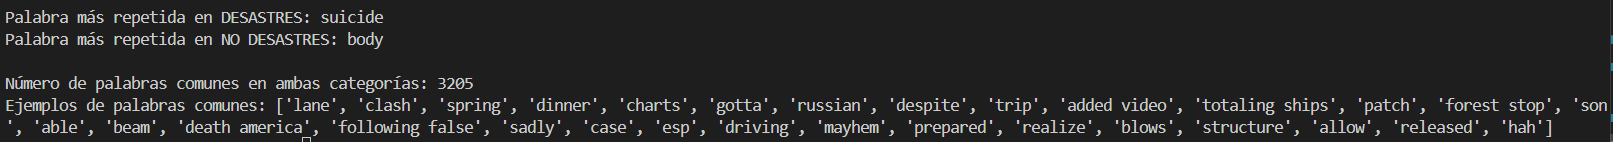

In [ ]:
# 5.2 Nube de palabras
plt.figure(figsize=(10,5))
wc_disaster = WordCloud(width=800, height=400, background_color="white") \
    .generate_from_frequencies(dict(zip(feature_names, disaster_mean)))
plt.imshow(wc_disaster, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets de desastres (TF-IDF medio)")
plt.show()

plt.figure(figsize=(10,5))
wc_non_disaster = WordCloud(width=800, height=400, background_color="white") \
    .generate_from_frequencies(dict(zip(feature_names, non_disaster_mean)))
plt.imshow(wc_non_disaster, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets de NO desastres (TF-IDF medio)")
plt.show()

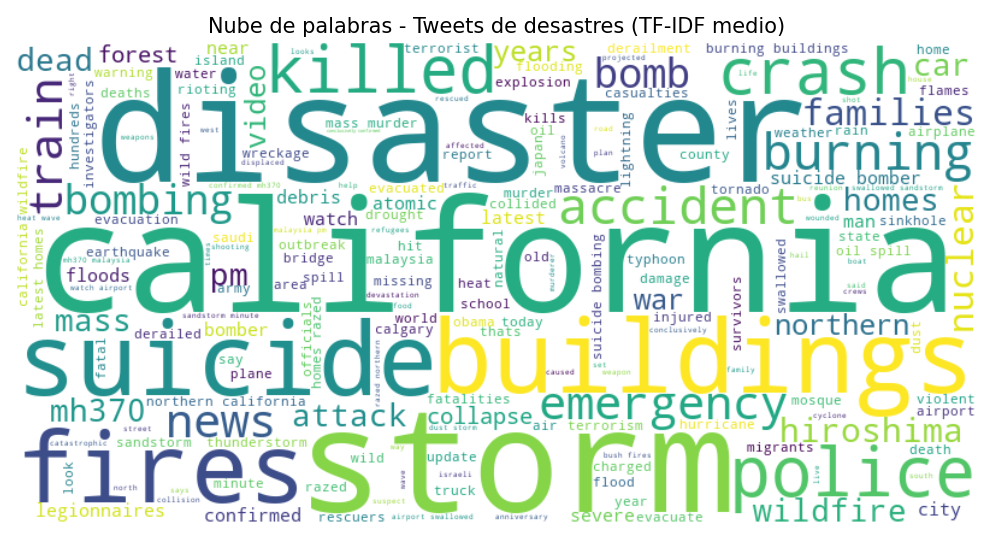

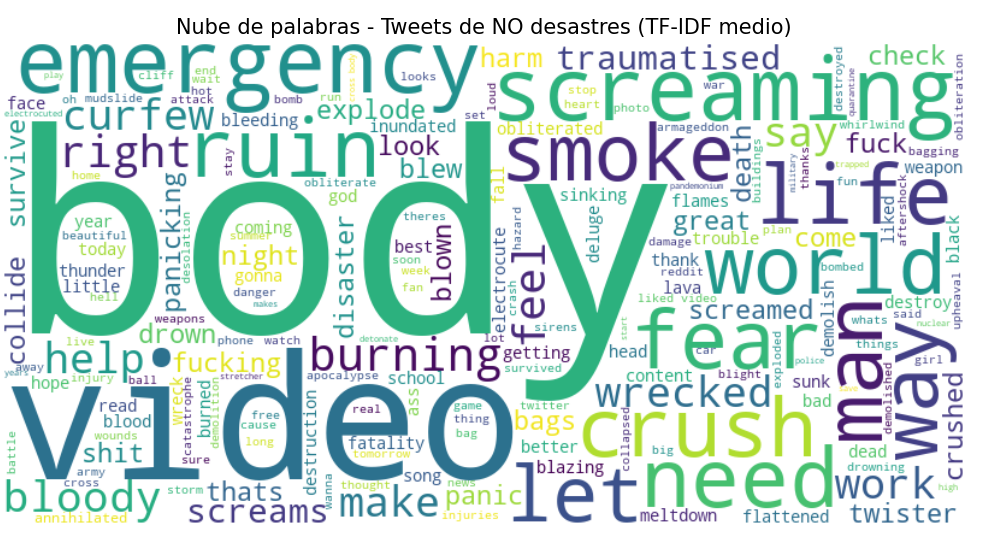

In [ ]:
# 5.3 Histogramas de las palabras más frecuentes 
def plot_top_bars(words, counts, title, k=20):
    idx = np.argsort(counts)[::-1][:k]
    sel_words = words[idx]
    sel_counts = counts[idx]
    plt.figure(figsize=(10,5))
    plt.bar(sel_words, sel_counts)
    plt.xticks(rotation=45, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_bars(vocab, disaster_counts, "Top 20 palabras en tweets de desastres (conteo)")
plot_top_bars(vocab, non_disaster_counts, "Top 20 palabras en tweets de NO desastres (conteo)")

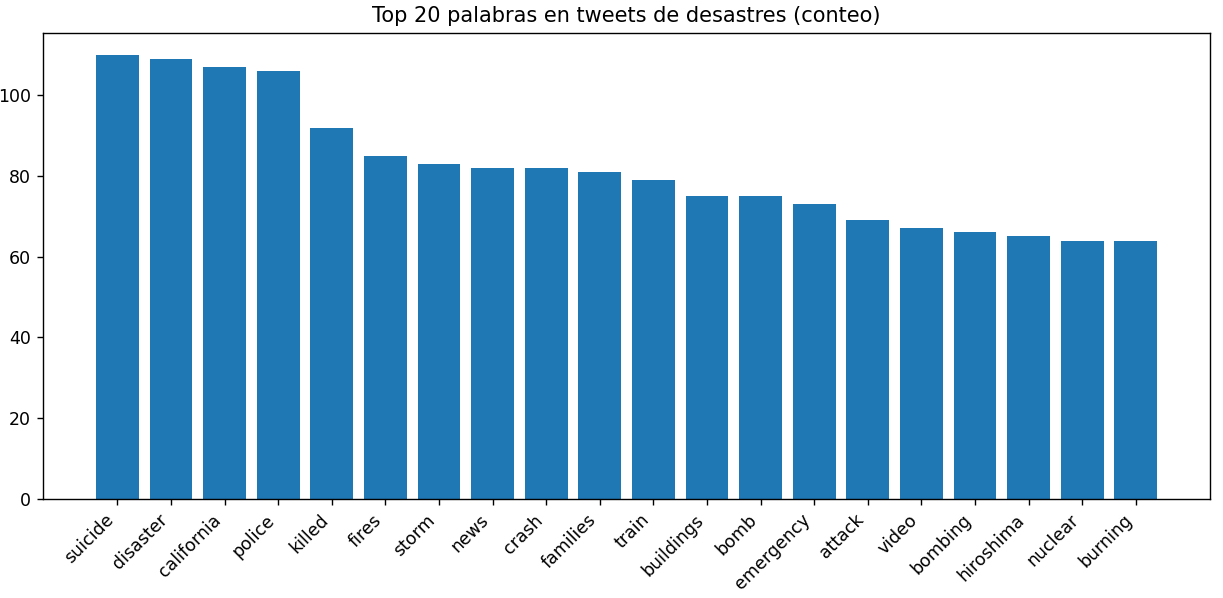

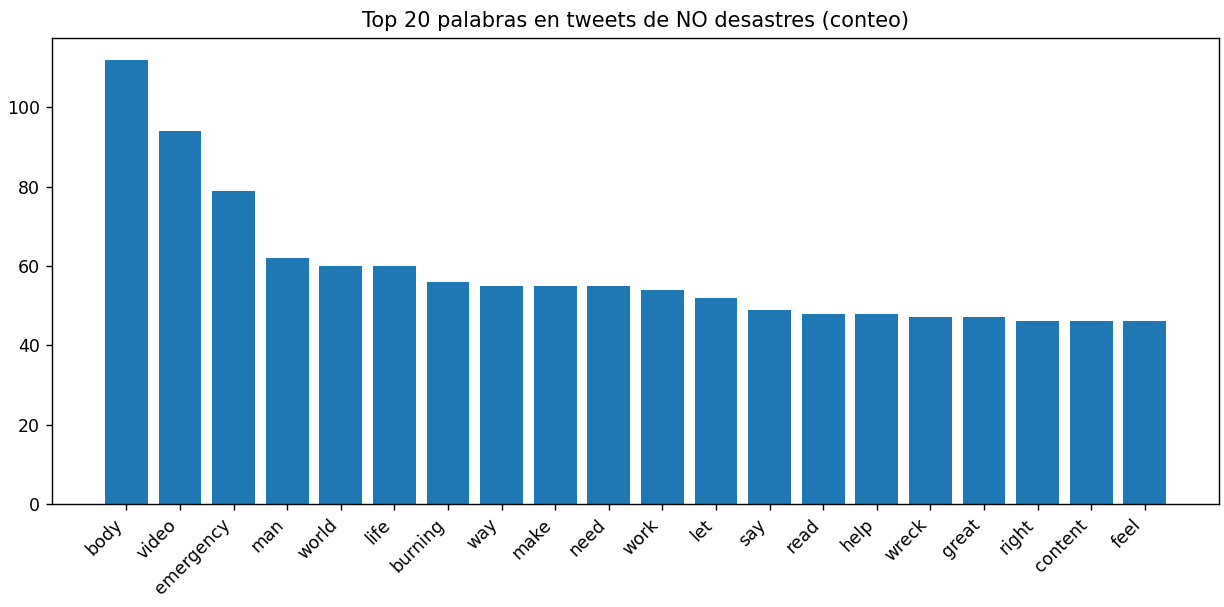

In [ ]:
# 5.4 Palabras presentes en ambas categorías
disaster_present_mask = disaster_counts > 0
non_disaster_present_mask = non_disaster_counts > 0
common_in_both = set(vocab[disaster_present_mask]) & set(vocab[non_disaster_present_mask])

print("\nNúmero de palabras comunes en ambas categorías:", len(common_in_both))
print("Ejemplos de palabras comunes:", list(common_in_both)[:30])

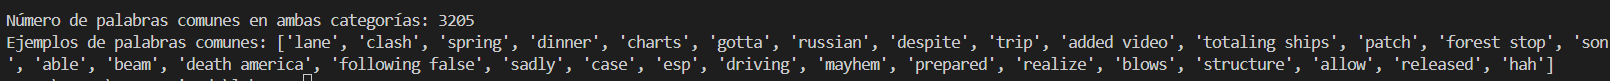

### 6) Descripción del modelo preliminar de clasificación

Para este problema de clasificación de tweets de desastre y no desastre natural, se pueden utilizar varios algoritmos de Machine Learning supervisado.

Podría usar Regresión logística el cuál es rápido y efectivo con texto, también podría ser Naive Bayes (multinomialNB) que es clásico para clasificación de texto, aprovecha la frecuencia de palabras. Support vector machine (SVM) igualmente funciona bien con texto y datos lineales o no lineales. Por otro lado está Random Forest con el que ya se está familiarizado, funciona bien en interacciones no lineales, pero si puede presentar menos eficiencia si el texto es muy disperso y Redes Neuronales simples (MPLClassifier) que permite capturar patrones más complejos.

Hay que tener en cuenta que se utilizaran no solo palabras individuales (unigramas), sino también bigramas (pared de palabras como "forest fire", "earthquake damage") y posiblemente trigramas, lo cual es un punto que ayuda a diferenciar o identificar entre desastres reales de expresiones figurativas.

Se seleccionaron los modelos de **Regresión Logística, Naive Bayes y Random Forest** para ver qué tal es su desempeño y si se comprueba su eficiencia en cuanto al manejo de texto.

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X = vectorizer.fit_transform(df["text"].astype(str))
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))

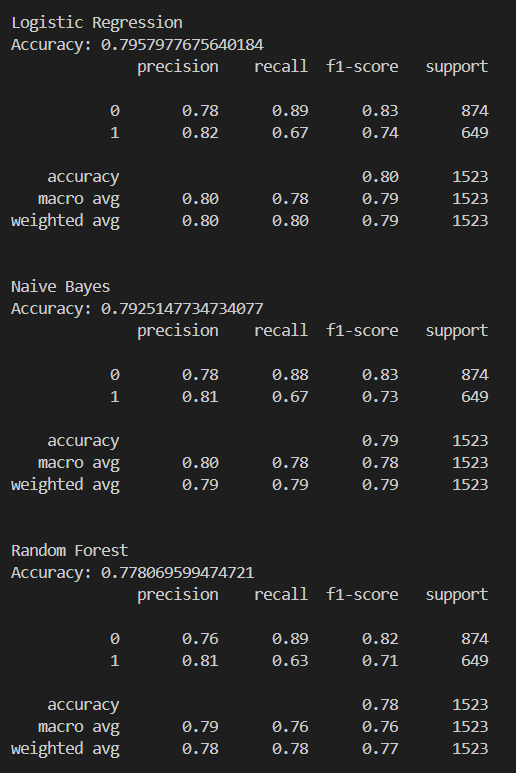

### 7) Función para clasificar un Tweet

In [ ]:
def clasificar_tweet(model, vectorizer):
    tweet = input("Escribe un tweet: ")
    tweetPre = clean_text(tweet)
    tweetVec = vectorizer.transform([tweetPre])
    pred = model.predict(tweetVec)[0]
    
    if pred == 1:
        print("Clasificación: ¡Desastre! :(")
    else:
        print("Clasificación: No Desastre :)")
    
clasificar_tweet(models["Logistic Regression"], vectorizer)

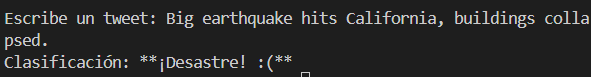

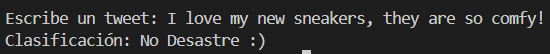

### 8) Análisis de sentimiento

In [ ]:
sia = SentimentIntensityAnalyzer()

def analizar_sentimiento(tweet):
    score = sia.polarity_scores(tweet)
    if score["compound"] >= 0.05:
        return "Positivo 😀", score
    elif score["compound"] <= -0.05:
        return "Negativo 😡", score
    else:
        return "Neutral 😐", score

# Ejemplo
print(analizar_sentimiento("I am so happy with the help after the earthquake"))
print(analizar_sentimiento("Terrible explosion killed many people"))

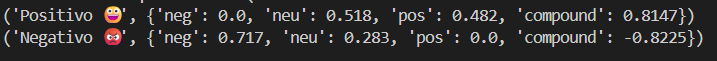

Si vale la pena dejar los emoticones ya que transmiten directamente las emociones, esto puede ayudar a mejorar la predicción.

### 9) top 10 tweets negativos y positivos

In [ ]:
df["sentiment"] = df["text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

# 9.1 Top negativos
top_negativos = df.sort_values("sentiment").head(10)[["text", "target", "sentiment"]]
print("\nTop 10 Negativos:\n", top_negativos)

# 9.2 Top positivos
top_positivos = df.sort_values("sentiment", ascending=False).head(10)[["text", "target", "sentiment"]]
print("\nTop 10 Positivos:\n", top_positivos)

# 9.3 Comparar negatividad entre categorias
promedio_negatividad = df.groupby("target")["sentiment"].mean()
print("\nPromedio de sentimiento por categoría (más bajo = más negativo):")
print(promedio_negatividad)

if promedio_negatividad[1] < promedio_negatividad[0]:
    print("Los tweets de DESASTRES son más negativos.")
else:
    print("Los tweets de NO DESASTRES son más negativos.")

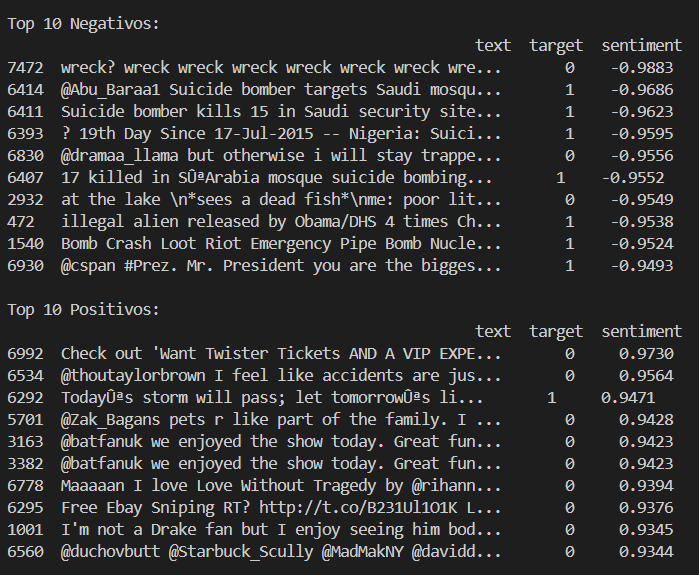

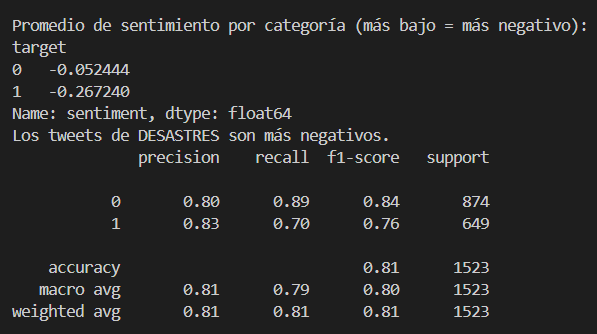

### 10) Análisis final de tweets

In [ ]:
sia = SentimentIntensityAnalyzer()

# Crear columna con la negatividad
df['negativity'] = df['text'].apply(lambda x: sia.polarity_scores(x)['neg'])
df[['text', 'negativity']].head()

Incluir la nueva variable en el dataset

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_text = vectorizer.fit_transform(df['text'])

# Concatenar la feature adicional
import numpy as np
X = hstack([X_text, np.array(df['negativity']).reshape(-1,1)])

y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Comparar resultados

In [ ]:
# Modelo SIN negatividad
X_text_only = vectorizer.fit_transform(df['text'])
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_text_only, y, test_size=0.2, random_state=42)

clf_text = LogisticRegression(max_iter=1000)
clf_text.fit(X_train_t, y_train_t)
y_pred_t = clf_text.predict(X_test_t)

print("Resultados SOLO texto:\n")
print(classification_report(y_test_t, y_pred_t))

# Modelo CON negatividad 
print("Resultados TEXTO + negatividad:\n")
print(classification_report(y_test, y_pred))

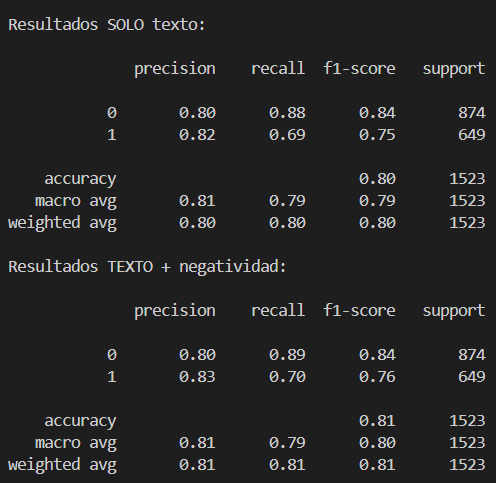

Discusión de los resultados

Al incluir la variable de negatividad en el modelo de clasificación, se observa una ligera mejoría en las métricas, como ejemplo, el F1-score para la clase “desastre” aumentó de 0.75 a 0.76, asimismo, la precisión es similar lo que indica que ambos modelos tienen un buen rendimiento. Esto sugiere que la información semántica sobre el tono negativo del tweet aporta señales útiles al modelo. Sin embargo, la mejora no es drástica, lo que indica que la representación TF-IDF ya captura gran parte de las características discriminativas.